In [1]:
# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, make_scorer
from scipy.stats import skew
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
ridge = Ridge()
lasso = Lasso()
net   = ElasticNet()
from scipy.stats.stats import pearsonr
%matplotlib inline
from subprocess import check_output
import matplotlib

In [2]:
# Get data
train = pd.read_csv("train.csv")
test = pd.read_csv('test.csv')

In [3]:
# drop alley column
# drop fence column
# drop garage yr blt??? ask elliot abt zeros
test.shape


(1459, 80)

In [4]:
# Drop Id column
train.drop(["Id","Street","PoolQC","Utilities","MiscFeature", "Alley"], axis = 1, inplace = True)
test.drop(["Id","Street","PoolQC","Utilities","MiscFeature", "Alley"],axis = 1, inplace = True)


In [5]:
train= train[train.YearBuilt> 1895]

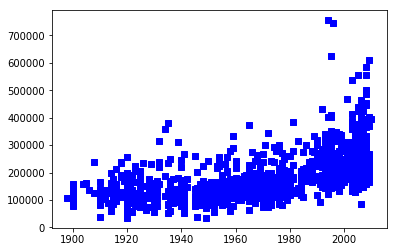

In [6]:
plt.scatter(train.YearBuilt, train.SalePrice, c = 'blue', marker = "s")

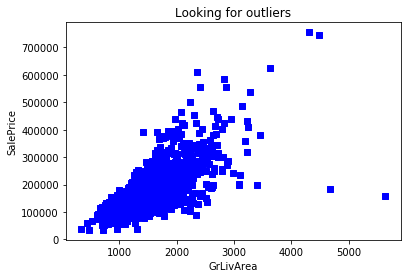

In [7]:
plt.scatter(train.GrLivArea, train.SalePrice, c = "blue", marker = "s")
plt.title("Looking for outliers")
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")
plt.show()

train = train[train.GrLivArea < 4000]

In [8]:
train1 = train.copy()
train1 = train1[train1.GrLivArea < 4000]

In [9]:
### Attempt at feature engineering
# train1['MoSold'].value_counts()
# categorize months into different seasons based on number of houses sold... 
# arr = []
# for i in range(0,1456):
#     if train['MoSold'].iloc[i] in [5, 6, 7]: 
#         arr.append('HotSzn')
#     elif train['MoSold'].iloc[i] in [3, 4, 8]:
#         arr.append('MediumSzn')
#     elif train['MoSold'].iloc[i] in [9, 10, 11]: 
#         arr.append('MildSzn')
#     else:
#         arr.append('ColdSzn')
# train['season'] = arr

In [10]:
train['Remodeled'] = (train['YearBuilt']==train['YearRemodAdd']).astype(int)
train['NewHouse'] = (train['YearBuilt']==train['YrSold']).astype(int)

In [11]:
# train.loc[train.Alley.isnull(), 'Alley'] = 'None'

In [12]:
train['MasVnrType'].fillna(value = 'None', inplace = True)
train['MasVnrArea'].replace(np.nan, 0, inplace = True)

In [13]:
train['Fence'].fillna('None', inplace = True)

In [14]:
train['FireplaceQu'].fillna('None', inplace = True)

In [15]:
###### Garage columns
### Seems like there are 81 houses with no garage...

train['GarageType'].fillna('None', inplace = True)
train['GarageCond'].fillna('None', inplace = True)
train['GarageFinish'].fillna('None', inplace = True)
train['GarageQual'].fillna('None', inplace = True)

# Use ZERO for this column
train['GarageYrBlt'].fillna(train['GarageYrBlt'].median(), inplace = True)

In [16]:
### basement crap
train['BsmtCond'].fillna('None', inplace = True)
train['BsmtQual'].fillna('None', inplace = True)
train['BsmtExposure'].fillna('None', inplace = True)
train['BsmtFinType2'].fillna('None', inplace = True)
train['BsmtFinType1'].fillna('None', inplace = True)

In [17]:
## use mode for the 1 missing electrical value 
train['Electrical'].fillna((train['Electrical'].value_counts().index[0]), inplace = True)

In [18]:
# use median for lot frontage
train['LotFrontage'].fillna((train['LotFrontage'].median()), inplace=True)

In [19]:
train.isnull().sum().sort_values(ascending=False)[:34]

NewHouse        0
BsmtCond        0
Exterior2nd     0
MasVnrType      0
MasVnrArea      0
ExterQual       0
ExterCond       0
Foundation      0
BsmtQual        0
BsmtExposure    0
CentralAir      0
BsmtFinType1    0
BsmtFinSF1      0
BsmtFinType2    0
BsmtFinSF2      0
BsmtUnfSF       0
TotalBsmtSF     0
Heating         0
Exterior1st     0
RoofMatl        0
RoofStyle       0
YearRemodAdd    0
MSZoning        0
LotFrontage     0
LotArea         0
LotShape        0
LandContour     0
LotConfig       0
LandSlope       0
Neighborhood    0
Condition1      0
Condition2      0
BldgType        0
HouseStyle      0
dtype: int64

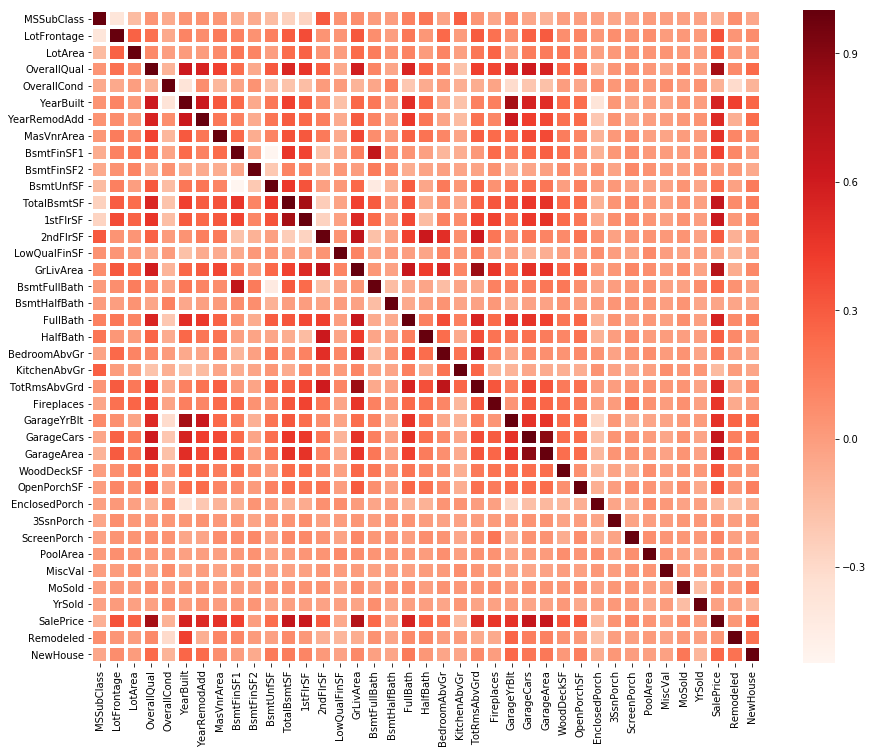

In [20]:
corrmat = train.corr()
f, ax = plt.subplots(figsize=(15, 12))
DWade = sns.heatmap(corrmat, linecolor = 'white', cmap = 'Reds', linewidths = 3)

In [21]:
# Encode some categorical features as ordered numbers when there is information in the order
# train = train.replace({
#                         "FireplaceQu" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
#                         "PavedDrive" : {"N" : 0, "P" : 1, "Y" : 2}

#                        })
                     

# #Changing some of the columns to ordinal values

## Basement cols
# Basement Condition
mapping4 = {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5}
train.replace({'BsmtCond': mapping4}, inplace = True)
# Basement Exposure
mapping5 = {"No" : 0,'None':0, "Mn" : 1, "Av": 2, "Gd" : 3}
train.replace({'BsmtExposure': mapping5}, inplace = True)
# Basement Qual
mapping6 = {"None" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5}
train.replace({'BsmtQual':mapping6}, inplace = True)
# Basement Fin type 1
mapping7 = {"None": 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, "ALQ" : 5, "GLQ" : 6}
train.replace({'BsmtFinType1':mapping7}, inplace = True)
# Basement Fin type 2
mapping8 = {"None": 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, "ALQ" : 5, "GLQ" : 6}
train.replace({'BsmtFinType2':mapping8}, inplace = True)

# Heating QC (quality)
mapping9 = {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5}
train.replace({'HeatingQC':mapping9},inplace = True)

## Garage cols
# garage cond
mapping10 = {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5}
train.replace({'GarageCond': mapping10}, inplace = True)
# garage qual
mapping11 = {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5}
train.replace({'GarageQual': mapping11}, inplace = True)

### home functionality
mapping12 = {"Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod": 5, 
                                       "Min2" : 6, "Min1" : 7, "Typ" : 8}
train.replace({'Functional': mapping12}, inplace = True)

## exterior
# exterior condition
mapping13 = {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5}
train.replace({'ExterCond': mapping13}, inplace = True)
# exterior quality
mapping14 = {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5}
train.replace({'ExterQual':mapping14}, inplace = True)

# kitchen quality
mapping15 = {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5}
train.replace({"KitchenQual": mapping15}, inplace = True)

# fireplace quality
mapping16 = {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5}
train.replace({'FireplaceQu': mapping16}, inplace = True)

In [22]:
train['FireplaceQu'].value_counts()

0    681
4    375
3    311
2     33
5     22
1     20
Name: FireplaceQu, dtype: int64

In [23]:
# Feature Engineering
# add ordinal basement columns
train['CombinedBsmt'] = train['BsmtQual'] + train['BsmtCond'] + train['BsmtExposure'] + train['BsmtFinType1']+train['BsmtFinType2']


In [24]:
train['ExterQual'].sample(5)

384     4
1291    3
377     4
555     3
875     4
Name: ExterQual, dtype: int64

In [25]:
train["Foundation"].value_counts()

PConc     642
CBlock    633
BrkTil    136
Slab       24
Stone       4
Wood        3
Name: Foundation, dtype: int64

In [26]:
train.groupby('Foundation', as_index=False)['YearBuilt'].median()

,Foundation,YearBuilt
0,BrkTil,1923.0
1,CBlock,1964.0
2,PConc,2002.0
3,Slab,1955.0
4,Stone,1925.5
5,Wood,1990.0


In [27]:
train.groupby('Foundation', as_index=False)['SalePrice'].mean()

,Foundation,SalePrice
0,BrkTil,127232.330882
1,CBlock,149893.875197
2,PConc,223920.320872
3,Slab,107365.625000
4,Stone,155569.000000
5,Wood,185666.666667


In [28]:
train['TotalBaths'] = train['FullBath']+train['BsmtFullBath']+(.5*train['HalfBath'])+(.5*train['BsmtHalfBath'])
train['TotalBaths2'] = (train['TotalBaths']**2)

In [29]:
train['FullBathTotal'] = train['FullBath'] + train['BsmtFullBath']
train['FullBathTotal'].value_counts()

2    745
1    364
3    316
4     15
6      1
0      1
Name: FullBathTotal, dtype: int64

In [30]:
train['HouseAge'] = train['YrSold']-train['YearBuilt']

In [31]:
np.arange(7,12)

array([ 7,  8,  9, 10, 11])

In [32]:
train['HouseAge'].value_counts().sort_index(ascending=True)

0       62
1      100
2       39
3       36
4       41
5       30
6       30
7       24
8       25
9       23
10      22
11      21
12      16
13      14
14      14
15      20
16      12
17      11
18       8
19       7
20       5
21       6
22       7
23       3
24       5
25       7
26       7
27       5
28       5
29      14
      ... 
80       5
81      13
82       5
83      12
84      13
85       5
86       9
87      11
88      12
89      14
90       6
91       6
92       4
93       7
94       6
95       3
96       6
97       7
98       3
99       4
100      3
102      1
103      1
104      1
106      3
107      1
108      3
109      1
110      2
111      1
Name: HouseAge, Length: 110, dtype: int64

In [33]:
# above ground SF plus basement SF
train["TotalSF"] = train["GrLivArea"] + train["TotalBsmtSF"]

In [34]:
train['HouseAge'].sample(5)

1405     4
530     20
957     45
134     38
66      40
Name: HouseAge, dtype: int64

In [35]:
# Overall quality and overall condition
train["OverallMult"] = train["OverallQual"] * train["OverallCond"]
train['OverallAdd'] = train['OverallQual'] + train['OverallCond']

In [36]:
# Exterior condition and quality
train['ExterMult'] = train['ExterCond'] * train['ExterQual']
train['ExterAdd'] = train['ExterCond'] + train['ExterQual']
train['ExterAdd2'] = (train['ExterAdd']**2)

In [37]:
# garage cond and qual
train['GarageMult'] = train['GarageCond'] * train['GarageQual']
train['GarageAdd'] = train['GarageCond'] + train['GarageQual']
train['GarageAdd2'] = (train['GarageAdd']**2)

In [38]:
#### assigning value to land slope
mapping = {'Gtl': 0, 'Mod': 1, 'Sev': 2}
train['LandSlopeVal'] = train.LandSlope.apply(lambda x: mapping[x])

In [39]:
### assigning value to lot Shape
mapping1 = {'Reg': 0, 'IR1': 1, 'IR3': 1, 'IR2':2}
train['LotShapeVal'] = train.LotShape.apply(lambda x: mapping1[x])

In [40]:
## assigning value to land contour
mapping2 = {'Bnk':0, "Low":1, "Lvl":1,"HLS":2}
train['LandContourVal'] = train.LandContour.apply(lambda x:mapping2[x])

In [41]:
### assigning value to lot config
mapping3 = {'Corner': 0, 'FR2':0, 'Inside':0,'FR3':0, 'CulDSac':1}
train['LotConfigVal'] = train.LotConfig.apply(lambda x: mapping3[x])

In [42]:
### layer value of overall cond and qual
train["OverallQualLayer"] = train.OverallQual.replace({1 : 1, 2 : 1, 3 : 1,
                                                       4 : 2, 5 : 2, 6 : 2,
                                                       7 : 3, 8 : 3, 9 : 3, 10 : 3})
train['OverallCondLayer'] = train.OverallCond.replace({1 : 1, 2 : 1, 3 : 1,
                                                       4 : 2, 5 : 2, 6 : 2,
                                                       7 : 3, 8 : 3, 9 : 3, 10 : 3})

In [43]:
#  adding new kitchen columns
train["KitchenMult"] = train["KitchenAbvGr"] * train["KitchenQual"]
train["KitchenAdd"] = train["KitchenAbvGr"] + train["KitchenQual"]
train["KitchenAdd2"] = (train["KitchenAdd"] ** 2)

In [44]:
medianbyyear = train.groupby('YrSold')['SalePrice'].agg('median').to_dict()
train['MedianPriceByYear'] = train.YrSold.apply(lambda x : medianbyyear[x])

In [45]:
salePrice = train1['SalePrice']

In [46]:
train.loc[:,['YrSold', 'MedianPriceByYear']].sample(5)

,YrSold,MedianPriceByYear
1388,2009,162000
1225,2007,167000
703,2010,155000
1216,2010,155000
995,2006,163995


In [47]:
train['YrSold'].value_counts()

2009    334
2007    323
2006    312
2008    300
2010    173
Name: YrSold, dtype: int64

In [48]:
# numerical_features=train.select_dtypes(include=['int64','float64'])
# categorical_features=train.select_dtypes(include=['object'])
categorical_features = train.select_dtypes(include = ["object"]).columns
numerical_features = train.select_dtypes(exclude = ["object"]).columns
numerical_features = numerical_features.drop("SalePrice")
print("Numerical features : " + str(len(numerical_features)))
print("Categorical features : " + str(len(categorical_features)))
train_num = train[numerical_features]
train_cat = train[categorical_features]

Numerical features : 73
Categorical features : 27


In [49]:
### handling skewed numerical columns

# log skewness with an absolute value > 0.5
skewness = train_num.apply(lambda x: skew(x))
skewness = skewness[abs(skewness) > 0.5]
print(str(skewness.shape[0]) + " skewed numerical features to log transform")
skewed_features = skewness.index
train_num[skewed_features] = np.log1p(train_num[skewed_features])

# for i in skewed_rows:
#     num_feats[i]= boxcox1p(num_feats[i], boxcox_normmax(num_feats[i]+1))

53 skewed numerical features to log transform


C:\Users\jdsip\anaconda3\lib\site-packages\pandas\core\frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [50]:
# Create dummy features for categorical values via one-hot encoding
train_cat = pd.get_dummies(train_cat)

In [51]:
# Join categorical and numerical features
train = pd.concat([train_num, train_cat], axis = 1)
print("New number of features : " + str(train.shape[1]))


New number of features : 272


In [52]:
def Penalization_term(beta, alpha, rho = 0, penalize='Ridge'):
    if penalize not in ['Ridge', 'Lasso', 'ElasticNet']: raise ValueError('The token ${\bf penalize}$ is invalid!')
    if penalize == 'Ridge':
            return alpha * np.sum(beta[1:]**2)
    elif penalize == 'Lasso':
            return alpha * np.sum(np.abs(beta[1:]))
    elif penalize == 'ElasticNet':
            return alpha * (rho * np.sum(np.abs(beta[1:])) + (1 - rho) * np.sum(beta[1:]**2))

In [53]:
test = test[test.GrLivArea < 4000]

In [54]:
test.shape

(1458, 74)

In [55]:
train1 = train1[train1.GrLivArea < 4000]

In [56]:
salePrice = train1['SalePrice']

In [57]:
ridge.set_params(alpha=1.0)
ridge.fit(train, salePrice)
ridge.score(train, salePrice)
pd.Series(ridge.coef_, index= train.columns)

MSSubClass               -2660.830664
LotFrontage               1112.921345
LotArea                  19262.723042
OverallQual               7777.905217
OverallCond              14032.394088
YearBuilt                 3599.349488
YearRemodAdd                56.085105
MasVnrArea                2636.356579
ExterQual                -1759.897912
ExterCond               -17206.379473
BsmtQual                 21122.358689
BsmtExposure              5767.797871
BsmtFinType1              -445.071196
BsmtFinSF1                1557.606902
BsmtFinType2              2983.337469
BsmtFinSF2               -1702.819155
BsmtUnfSF                -1539.675881
TotalBsmtSF                 51.596675
HeatingQC                 3094.320489
1stFlrSF                 30952.289653
2ndFlrSF                  5556.656509
LowQualFinSF              1813.951576
GrLivArea                29022.010632
BsmtFullBath             19052.804106
BsmtHalfBath             12966.051051
FullBath                 14735.979997
HalfBath    

In [58]:
lasso.set_params(alpha=1, normalize=True)

Lasso(alpha=1, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
   positive=False, precompute=False, random_state=None, selection='cyclic',
   tol=0.0001, warm_start=False)

In [59]:
lasso.fit(train, salePrice)
print('The intercept is %.4f' %(lasso.intercept_))
lassoCoef = pd.Series(lasso.coef_, index=train.columns)
print('The slopes are \n%s' %(lassoCoef))

The intercept is -1689197.2717
The slopes are 
MSSubClass                -2389.392192
LotFrontage                  35.809515
LotArea                   20130.359882
OverallQual               26200.225546
OverallCond              143476.396395
YearBuilt                321845.524493
YearRemodAdd                 87.673982
MasVnrArea                 2029.956771
ExterQual                    -0.000000
ExterCond                -14366.713816
BsmtQual                  18033.228083
BsmtExposure               4187.590194
BsmtFinType1               -869.335153
BsmtFinSF1                 1329.526822
BsmtFinType2               -863.877341
BsmtFinSF2                -1532.650697
BsmtUnfSF                 -1420.253920
TotalBsmtSF                  46.046684
HeatingQC                  3799.899538
1stFlrSF                  29733.664083
2ndFlrSF                   4527.141672
LowQualFinSF               1465.514756
GrLivArea                 33954.990009
BsmtFullBath              34508.461622
BsmtHalfBath     

C:\Users\jdsip\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001EFCC596EB8>,
      dtype=object)

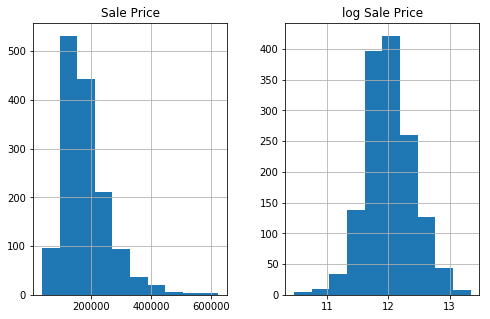

In [60]:
# Data PreProcessing
new_price = {"Sale Price":train1["SalePrice"], "log Sale Price":np.log1p(train1["SalePrice"])}
prices = pd.DataFrame(new_price)
matplotlib.rcParams['figure.figsize'] = (8.0, 5.0)
prices.hist()

In [61]:
#log transform the target:
salePrice = np.log1p(train1["SalePrice"])


In [62]:
X_train = train[:train.shape[0]]

In [63]:
X_test = train[train.shape[0]:]

In [64]:
print(X_train.shape)
print(X_test.shape)

(1442, 272)
(0, 272)


In [65]:
###Model Ridge regression
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score
cross_val_score(ridge, X_train, salePrice, scoring="neg_mean_squared_error", cv = 5)

array([-0.01083161, -0.01360651, -0.01548245, -0.01233969, -0.01327356])

In [66]:
rmse_ridge = np.sqrt(-cross_val_score(ridge, X_train, salePrice, scoring="neg_mean_squared_error", cv = 5))
rmse_ridge

array([0.10407504, 0.11664695, 0.1244285 , 0.11108416, 0.11521096])

Text(0, 0.5, 'rmse')

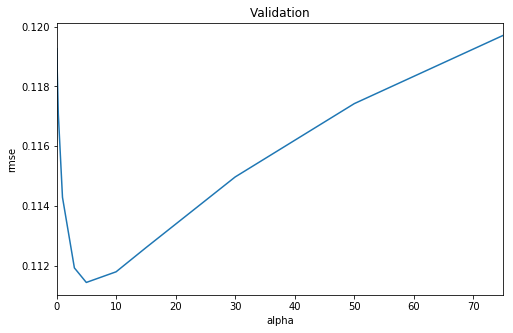

In [67]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, salePrice, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation")
plt.xlabel("alpha")
plt.ylabel("rmse")

(array([  3.,   1.,   3.,  10.,  66., 402., 750., 187.,  17.,   3.]),
 array([-0.66849517, -0.56119672, -0.45389828, -0.34659984, -0.23930139,
        -0.13200295, -0.02470451,  0.08259394,  0.18989238,  0.29719082,
         0.40448927]),
 <a list of 10 Patch objects>)

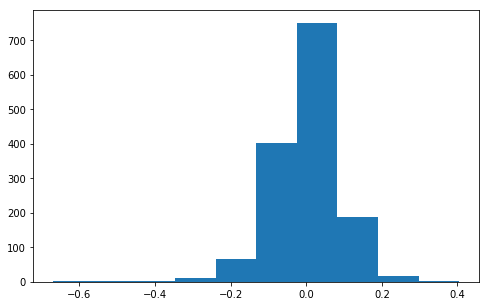

In [68]:
from sklearn.linear_model import LinearRegression

lm = LinearRegression()
lm.fit(train, salePrice)
residuals = salePrice - lm.predict(train)
plt.hist(residuals)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001EFCC71A4E0>,
      dtype=object)

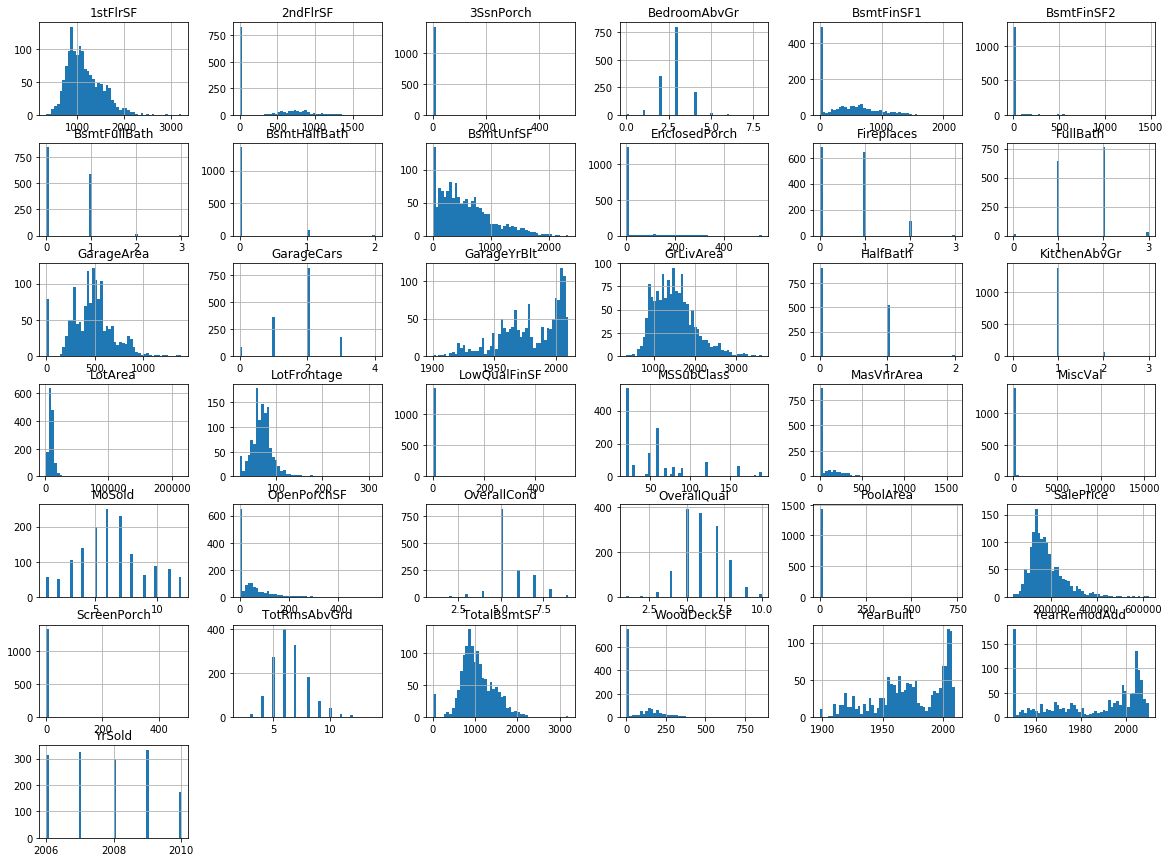

In [69]:
train1.hist(bins=50, figsize=(20,15))

(1153, 272) (1153,)
(289, 272) (289,)
Score:  0.9044394477824145
R^2 is equal to 0.943
RSS is equal to 12.830


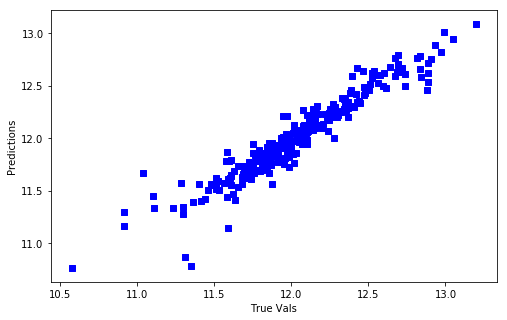

In [70]:
# create training and testing vars
X_train, X_test, y_train, y_test = train_test_split(train, salePrice, test_size=0.2)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

# fit a model
lm = LinearRegression()
model = lm.fit(X_train, y_train)
predictions = lm.predict(X_test)

## The line / model
plt.scatter(y_test, predictions,color = "blue", marker ="s", label = "Training data")
plt.xlabel("True Vals")
plt.ylabel("Predictions")

print ("Score: ", model.score(X_test, y_test))
print('R^2 is equal to %.3f' %(lm.score(train, salePrice)))
print('RSS is equal to %.3f' %(np.sum((salePrice-lm.predict(train))**2)))

In [71]:
train1['Foundation'].value_counts()

PConc     642
CBlock    633
BrkTil    136
Slab       24
Stone       4
Wood        3
Name: Foundation, dtype: int64

In [79]:
train['SalePrice']

KeyError: 'SalePrice'

In [72]:
# corrmat = train.corr()
# k = 20
# cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
# cm = np.corrcoef(train[cols].values.T)
# sns.set(font_scale = 1.2)
# Dwade = sns.heatmap(cm, cbar = True, annot= True, square = True, fmt = '.2f', annot_kws={'size':6},
#                    yticklabels = cols.values, xticklabels = cols.values)
# plt.show()

In [73]:
# corrmat = train.corr()
# k = 10
# cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
# cm = np.corrcoef(train[cols].values.T)
# sns.set(font_scale = 1.2)
# Dwade = sns.heatmap(cm, cbar = True, annot= True, square = True, fmt = '.2f', annot_kws={'size':10},
#                    yticklabels = cols.values, xticklabels = cols.values)
# plt.show()

In [80]:
def scatter_plot(feature):
    plt.figure(figsize =(16,8))
    plt.scatter(
        train[feature],
        train1['SalePrice'],
        c = 'blue'
    )
    plt.xlabel("{}".format(feature))
    plt.ylabel("Sale Price")
    plt.show()

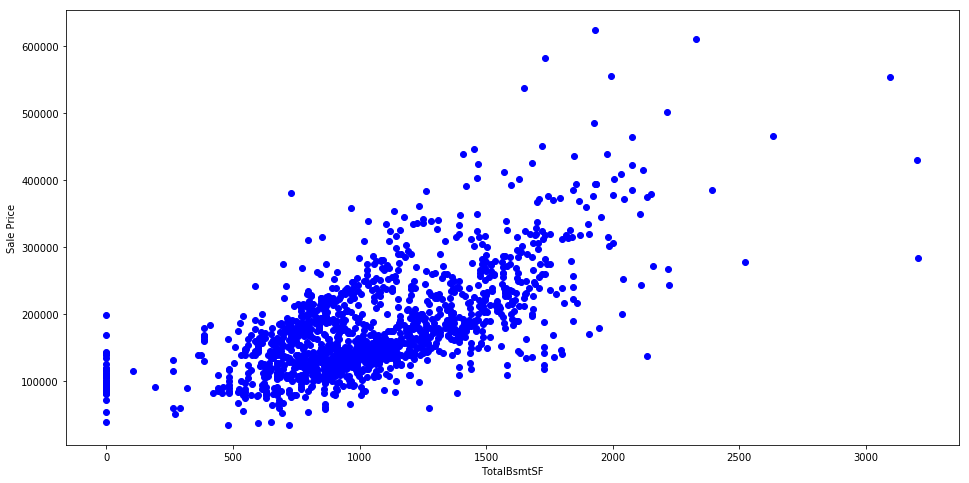

In [82]:
scatter_plot('TotalBsmtSF')